# Data Quality Check - Visual Analysis

This notebook performs quality checks on property images using Vision Language Models (VLMs) to assess:
- Image clarity and visibility
- House visibility
- Address visibility (postal numbers/plates)

We'll test on a sample of images first, then scale up if needed.


In [1]:
import os
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image, Markdown
from src.data_loader import DataLoader
from src.providers import get_provider
from src.config import Config

# Set up plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Load annotations
loader = DataLoader()
df = loader.load_annotations()

print(f"📊 Total images: {len(df)}")
print(f"📊 Images with expert scores: {df['expert_score'].notna().sum()}")
print(f"📊 Images without expert scores: {df['expert_score'].isna().sum()}")

# Get all image paths
all_images = df['image_path'].tolist()
existing_images = [img for img in all_images if os.path.exists(img)]

print(f"\n✅ Found {len(existing_images)} existing images out of {len(all_images)} total")


📊 Total images: 1856
📊 Images with expert scores: 1686
📊 Images without expert scores: 170

✅ Found 1856 existing images out of 1856 total


In [3]:
# Load quality check prompt
prompt_path = os.path.join(Config.PROMPTS_DIR, "quality_check.txt")
with open(prompt_path, "r") as f:
    quality_prompt = f.read()

print("Quality Check Prompt:")
print("=" * 80)
print(quality_prompt[:500] + "...")
print("=" * 80)


Quality Check Prompt:
Analyze this property condition assessment image and return ONLY a valid JSON object with the following structure:

{
    "is_clear": boolean,
    "house_visible": boolean,
    "address_visible": boolean,
    "address_text": string (if visible, otherwise empty string),
    "reason": string (brief explanation of your assessment)
}

Assessment criteria:
- **is_clear**: Is the image clear and not blurry? Can you see details?
- **house_visible**: Is a house/property structure clearly visible in the ...


In [4]:
# Select random sample for pilot test
SAMPLE_SIZE = 10
random.seed(42)
sample_images = random.sample(existing_images, min(SAMPLE_SIZE, len(existing_images)))

print(f"🎲 Selected {len(sample_images)} random images for pilot test")
print("\nSample images:")
for i, img_path in enumerate(sample_images[:5], 1):
    print(f"  {i}. {os.path.basename(img_path)}")


🎲 Selected 10 random images for pilot test

Sample images:
  1. ATT7992_PropertyConditionAssessment_image-20220808-152207.jpg
  2. ATT35353_PropertyConditionAssessment_image-20220907-182738.jpg
  3. ATT13504_PropertyConditionAssessment_image-20220901-173305.jpg
  4. ATT10197_PropertyConditionAssessment_image-20220812-184821.jpg
  5. ATT2868_PropertyConditionAssessment_image-20220701-174337.jpg


In [5]:
# Initialize provider (using local Ollama by default)
provider_name = "local"  # Change to "openai", "google", or "together" if needed
provider = get_provider(provider_name)

print(f"✅ Using provider: {provider_name}")
print(f"✅ Model: {provider.model_name}")


✅ Using provider: local
✅ Model: gemma3:27b


In [6]:
# Run quality check on sample images
results = []

for idx, img_path in enumerate(sample_images, 1):
    print(f"\n[{idx}/{len(sample_images)}] Processing: {os.path.basename(img_path)}")
    
    if not os.path.exists(img_path):
        results.append({
            "image_path": img_path,
            "error": "File not found"
        })
        continue
    
    try:
        response = provider.analyze(img_path, quality_prompt)
        
        if response:
            # Try to parse JSON from response
            clean_response = response.strip()
            if "```json" in clean_response:
                clean_response = clean_response.split("```json")[1].split("```")[0].strip()
            elif "```" in clean_response:
                clean_response = clean_response.split("```")[1].split("```")[0].strip()
            
            try:
                parsed = json.loads(clean_response)
                parsed["image_path"] = img_path
                parsed["file_name"] = os.path.basename(img_path)
                results.append(parsed)
                print(f"  ✅ Parsed successfully")
            except json.JSONDecodeError:
                results.append({
                    "image_path": img_path,
                    "file_name": os.path.basename(img_path),
                    "raw_response": response,
                    "error": "Failed to parse JSON"
                })
                print(f"  ⚠️  Failed to parse JSON")
        else:
            results.append({
                "image_path": img_path,
                "file_name": os.path.basename(img_path),
                "error": "Empty response"
            })
    except Exception as e:
        results.append({
            "image_path": img_path,
            "file_name": os.path.basename(img_path),
            "error": str(e)
        })
        print(f"  ❌ Error: {e}")

results_df = pd.DataFrame(results)
print(f"\n✅ Completed quality check on {len(results_df)} images")



[1/10] Processing: ATT7992_PropertyConditionAssessment_image-20220808-152207.jpg
  ✅ Parsed successfully

[2/10] Processing: ATT35353_PropertyConditionAssessment_image-20220907-182738.jpg
  ✅ Parsed successfully

[3/10] Processing: ATT13504_PropertyConditionAssessment_image-20220901-173305.jpg
  ✅ Parsed successfully

[4/10] Processing: ATT10197_PropertyConditionAssessment_image-20220812-184821.jpg
  ✅ Parsed successfully

[5/10] Processing: ATT2868_PropertyConditionAssessment_image-20220701-174337.jpg
  ✅ Parsed successfully

[6/10] Processing: ATT2509_PropertyConditionAssessment_image-20220630-182555.jpg
  ✅ Parsed successfully

[7/10] Processing: ATT1973_PropertyConditionAssessment_image-20220628-193431.jpg
  ✅ Parsed successfully

[8/10] Processing: ATT36226_PropertyConditionAssessment_image-20220908-202258.jpg
  ✅ Parsed successfully

[9/10] Processing: ATT9974_PropertyConditionAssessment_image-20220812-162049.jpg
  ✅ Parsed successfully

[10/10] Processing: ATT20489_PropertyCond

In [7]:
# Display results
display(results_df)


,is_clear,house_visible,address_visible,address_text,reason,image_path,file_name
0,True,True,True,821,"The image is clear, a house is visible, and a ...",/home/exouser/DSM-property-condition-assessmen...,ATT7992_PropertyConditionAssessment_image-2022...
1,True,True,False,,"The image is clear and a house is visible, but...",/home/exouser/DSM-property-condition-assessmen...,ATT35353_PropertyConditionAssessment_image-202...
2,True,True,False,,"The image is clear and shows a house, but no v...",/home/exouser/DSM-property-condition-assessmen...,ATT13504_PropertyConditionAssessment_image-202...
3,True,True,True,786,The image is clear and shows a house with a vi...,/home/exouser/DSM-property-condition-assessmen...,ATT10197_PropertyConditionAssessment_image-202...
4,True,True,False,,The image is clear and shows the house. There ...,/home/exouser/DSM-property-condition-assessmen...,ATT2868_PropertyConditionAssessment_image-2022...
5,True,True,True,612,"The image is clear, a house is visible, and a ...",/home/exouser/DSM-property-condition-assessmen...,ATT2509_PropertyConditionAssessment_image-2022...
6,True,True,True,227,"The image is clear, a house is clearly visible...",/home/exouser/DSM-property-condition-assessmen...,ATT1973_PropertyConditionAssessment_image-2022...
7,True,True,False,,"The image is clear, a house is visible, but th...",/home/exouser/DSM-property-condition-assessmen...,ATT36226_PropertyConditionAssessment_image-202...
8,True,True,True,615,"The image is clear, a house is visible, and a ...",/home/exouser/DSM-property-condition-assessmen...,ATT9974_PropertyConditionAssessment_image-2022...
9,True,True,False,,"The image is clear and a house is visible, but...",/home/exouser/DSM-property-condition-assessmen...,ATT20489_PropertyConditionAssessment_image-202...


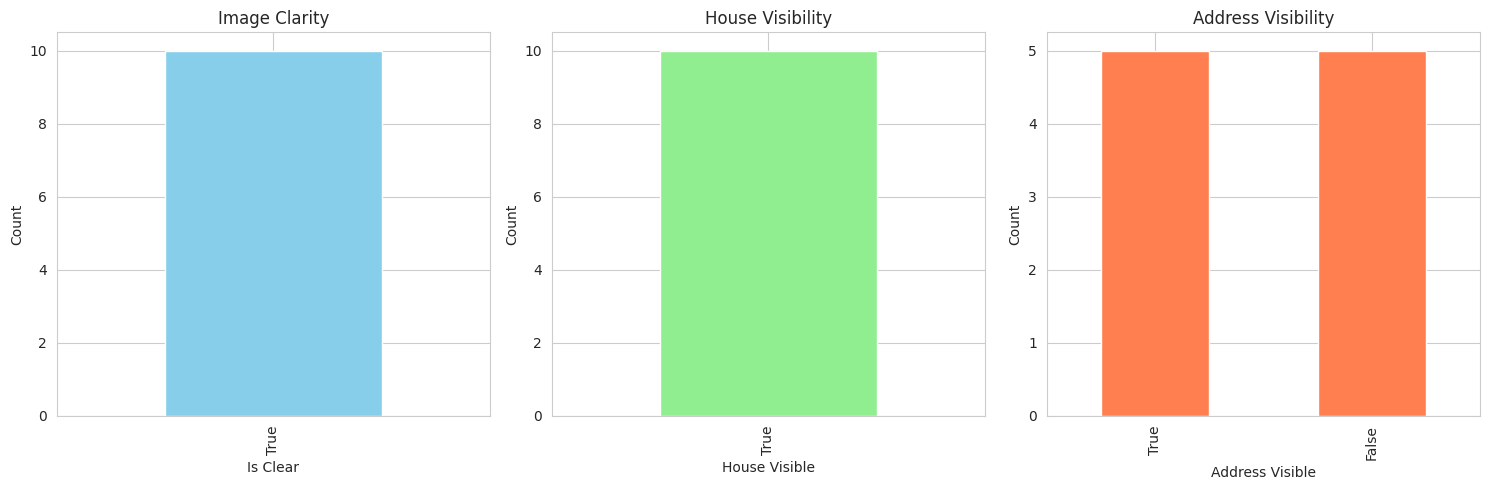

In [8]:
# Visualize results
if 'is_clear' in results_df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Clarity distribution
    if results_df['is_clear'].notna().any():
        results_df['is_clear'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
        axes[0].set_title('Image Clarity')
        axes[0].set_xlabel('Is Clear')
        axes[0].set_ylabel('Count')
    
    # House visibility
    if 'house_visible' in results_df.columns and results_df['house_visible'].notna().any():
        results_df['house_visible'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen')
        axes[1].set_title('House Visibility')
        axes[1].set_xlabel('House Visible')
        axes[1].set_ylabel('Count')
    
    # Address visibility
    if 'address_visible' in results_df.columns and results_df['address_visible'].notna().any():
        results_df['address_visible'].value_counts().plot(kind='bar', ax=axes[2], color='coral')
        axes[2].set_title('Address Visibility')
        axes[2].set_xlabel('Address Visible')
        axes[2].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Quality metrics not found in results. Check the VLM response format.")


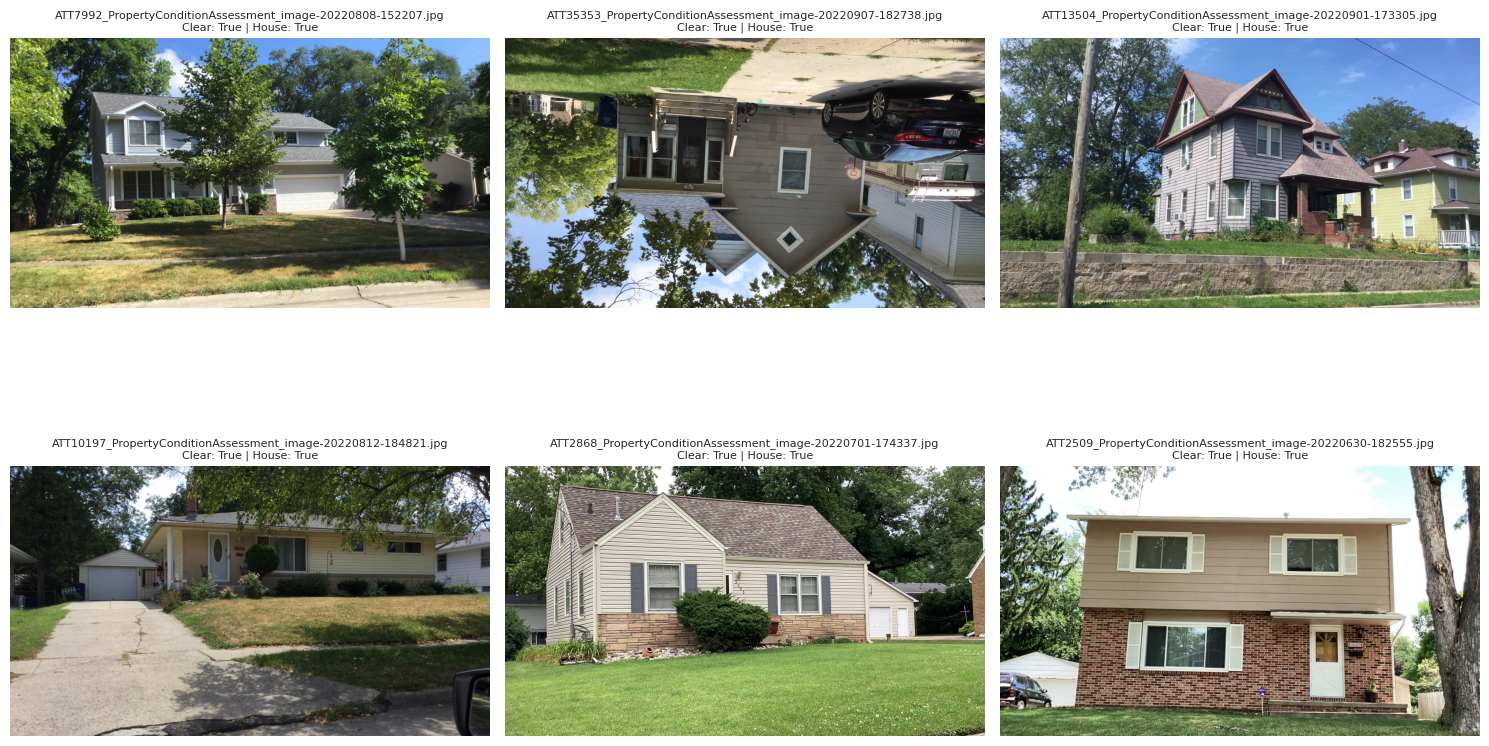

In [9]:
# Display sample images with their quality assessments
if len(results_df) > 0 and 'file_name' in results_df.columns:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (_, row) in enumerate(results_df.head(6).iterrows()):
        img_path = row['image_path']
        if os.path.exists(img_path):
            img = plt.imread(img_path)
            axes[idx].imshow(img)
            axes[idx].axis('off')
            
            title = os.path.basename(img_path)
            if 'is_clear' in row and pd.notna(row['is_clear']):
                title += f"\nClear: {row['is_clear']}"
            if 'house_visible' in row and pd.notna(row['house_visible']):
                title += f" | House: {row['house_visible']}"
            axes[idx].set_title(title, fontsize=8)
    
    # Hide unused subplots
    for idx in range(len(results_df.head(6)), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()


## Hypothesis Testing: Are unscored images unclear/invisible?

Let's check if images without expert scores are more likely to be unclear or have visibility issues.


IndexError: index 0 is out of bounds for axis 0 with size 0

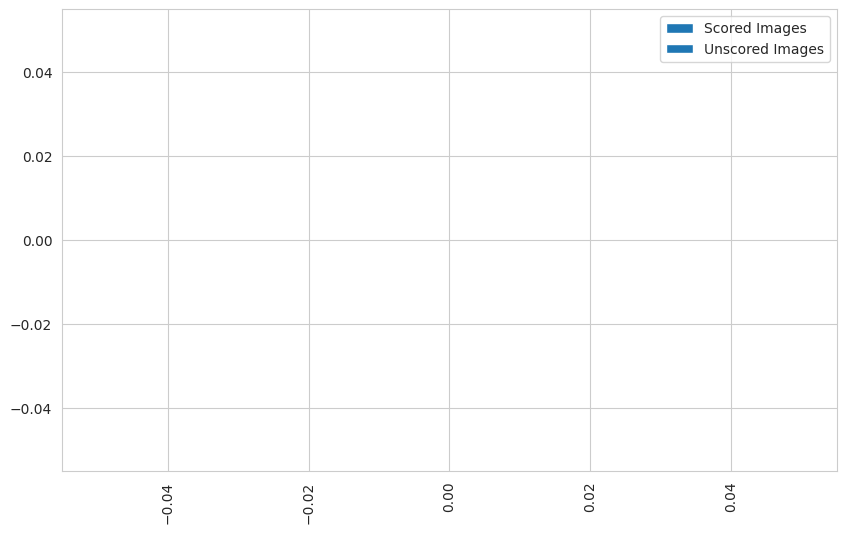

In [11]:
# Merge quality results with annotation data
if len(results_df) > 0:
    # Get file names from results
    results_df['file_name'] = results_df['image_path'].apply(os.path.basename)
    
    # Merge with original annotations
    merged_df = df.merge(results_df, on='file_name', how='left', suffixes=('', '_quality'))
    
    # Compare scored vs unscored images
    if 'is_clear' in merged_df.columns:
        scored_clear = merged_df[merged_df['expert_score'].notna()]['is_clear'].value_counts()
        unscored_clear = merged_df[merged_df['expert_score'].isna()]['is_clear'].value_counts()
        
        comparison = pd.DataFrame({
            'Scored Images': scored_clear,
            'Unscored Images': unscored_clear
        }).fillna(0)
        
        comparison.plot(kind='bar', figsize=(10, 6))
        plt.title('Image Clarity: Scored vs Unscored Images')
        plt.xlabel('Is Clear')
        plt.ylabel('Count')
        plt.legend()
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        print("\n📊 Clarity Comparison:")
        print(comparison)


In [ ]:
# Save results
output_dir = Config.OUTPUTS_DIR
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, "quality_check_pilot.csv")
results_df.to_csv(output_path, index=False)
print(f"✅ Results saved to: {output_path}")
